In [1]:
import pandas as pd
import os
import numpy as np
from abag_affinity.utils.config import read_yaml, get_data_paths

In [2]:
config = read_yaml("../abag_affinity/config.yaml")
sabdab_summary_path, sabdab_pdb_path = get_data_paths(config, "SAbDab")
sabdab_df = pd.read_csv(sabdab_summary_path, sep="\t")

In [3]:
sabdab_df.head()

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,1mhh,D,C,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,08/20/02,...,False,False,IGHV9,IGKV8,Kappa,1.000000e-09,-12.278197,Unknown,NaN,TBD
1,1mhh,B,A,0,NaN,NaN,NaN,NaN,IMMUNE SYSTEM,08/20/02,...,False,False,IGHV9,IGKV8,Kappa,1.000000e-09,-12.278197,Unknown,NaN,TBD
2,1mh5,H,L,0,H,Hapten,HAL,N-{[2-({[1-(4-CARBOXYBUTANOYL)AMINO]-2-PHENYLE...,IMMUNE SYSTEM,08/19/02,...,False,True,IGHV1,IGKV2,Kappa,6.100000e-10,-12.571059,Unknown,NaN,TBD
3,1mh5,B,A,0,B,Hapten,HAL,N-{[2-({[1-(4-CARBOXYBUTANOYL)AMINO]-2-PHENYLE...,IMMUNE SYSTEM,08/19/02,...,False,True,IGHV1,IGKV2,Kappa,6.100000e-10,-12.571059,Unknown,NaN,TBD
4,2r56,I,M,0,B,protein,NaN,beta-lactoglobulin,IMMUNE SYSTEM,09/03/07,...,False,False,IGHV3,IGKV1,Kappa,1.300000e-09,-12.120000,SPR,NaN,17997967


In [4]:
def calc_residue_dist(residue_one, residue_two) :
    """Returns the C-alpha distance between two residues"""
    diff_vector  = residue_one["CA"].coord - residue_two["CA"].coord
    return np.sqrt(np.sum(diff_vector * diff_vector))

def calc_dist_matrix(chain_one, chain_two) :
    """Returns a matrix of C-alpha distances between two chains"""
    answer = np.zeros((len(chain_one), len(chain_two)), float)
    for row, residue_one in enumerate(chain_one):
        if "CA" not in residue_one:
            break
        for col, residue_two in enumerate(chain_two):
            if "CA" not in residue_two:
                break
            answer[row, col] = calc_residue_dist(residue_one, residue_two)
    
    return answer[:row, :col]

In [5]:
len(sabdab_df)

1326

## Quick Analysis of SARS Cov Spike Protein

In [6]:
from abag_affinity.utils.pdb_reader import read_file

row = sabdab_df[sabdab_df["pdb"] == "2DD8".lower()].iloc[0]  # sars-cov spike protein
path = os.path.join(sabdab_pdb_path, row["pdb"] + ".pdb")

#path = "../../data/test/1mhh.pdb"
print("Getting Strcuture for {}".format(row["pdb"]))
print("Binding Affinity >>>", row["affinity"])

structure, header= read_file(row["pdb"], path)
model = structure[0]

Getting Strcuture for 4xi5
Binding Affinity >>> 4.900000000000001e-10


/home/fabian/Desktop/Uni/Masterthesis/ag_binding_venv/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 10629.
  warnings.warn(
/home/fabian/Desktop/Uni/Masterthesis/ag_binding_venv/lib/python3.8/site-packages/Bio/PDB/StructureBuilder.py:89: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 10671.
  warnings.warn(


In [9]:
chains = list(model.get_chains())[:3]
chains

[<Chain id=A>, <Chain id=B>, <Chain id=C>]

In [10]:
dist_matrix = calc_dist_matrix(model["B"], model["C"])
contact_map = dist_matrix < 10.0

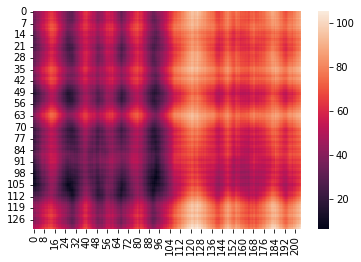

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(dist_matrix)

plt.show()

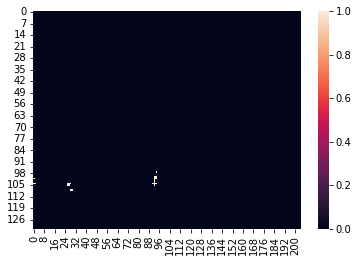

In [12]:
sns.heatmap(contact_map)
plt.show()

Check 3D Structure on https://www.rcsb.org/3d-sequence/2DD8?assemblyId=1

In [ ]:
fig, ax = plt.subplots(len(chains), len(chains), figsize=(20,15))
for i, chain in enumerate(chains):
    for j, chain_1 in enumerate(chains):
        dist_matrix = calc_dist_matrix(chain, chain_1)
        contact_map = dist_matrix < 10.0
        sns.heatmap(contact_map, ax=ax[i, j])
        ax[i, j].set_title(chain.id + " vs " + chain_1.id)
        
plt.show()

In [ ]:
from abag_affinity.utils.pdb_processing import get_distances_and_info
distances, residue_info, structure_info = get_distances_and_info(structure, header)
sns.heatmap(distances)

plt.show()

In [ ]:
contact_map = distances < 10.0
sns.heatmap(contact_map)

plt.show()

In [ ]:
residue_info